# Matplotlib環境中文化

In [ ]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib

# 改style要在改font之前
# plt.style.use('seaborn')

matplotlib.font_manager.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')

# 列舉下一個生成字的機率

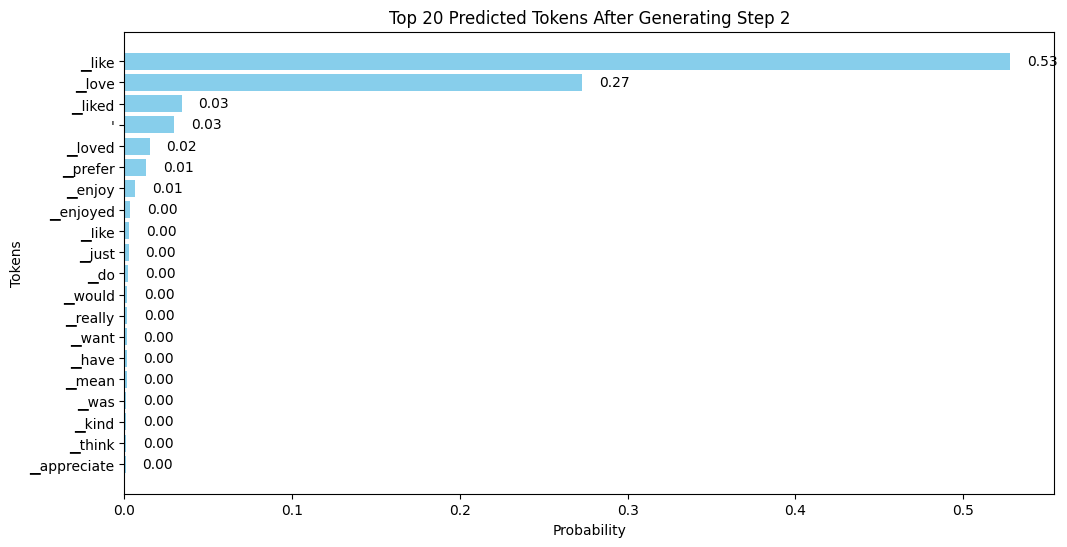

In [16]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# 設定全局浮點數格式，保留兩位小數
np.set_printoptions(precision=2, suppress=True)

# 載入模型
model_name = "Helsinki-NLP/opus-mt-zh-en"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# 輸入文本
input_text = "我喜歡機器學習，因為它十分迷人。"

# 編碼輸入
inputs = tokenizer(input_text, return_tensors="pt")

# 使用 generate 方法生成目標序列，並啟用 scores 返回
with torch.no_grad():
    output_sequences = model.generate(
        **inputs,
        output_attentions=True,
        return_dict_in_generate=True,
        output_scores=True,  # 確保傳回 logits
        max_length=10,  # 僅生成幾個字以方便觀察
        temperature=0.1  # 減少隨機性
    )

# 獲取 logits
logits = output_sequences.scores  # 生成過程中的 logits

# 獲取第 2 個字生成後的 logits
step = 2  # 第幾個字，索引從 0 開始，所以第 2 個字是 logits[1]
if len(logits) > step - 1:  # 確保 logits 的長度足夠
    next_step_logits = logits[step - 1]  # 第 2 步生成的 logits
    probs = torch.nn.functional.softmax(next_step_logits, dim=-1).cpu().numpy()  # 計算 softmax 機率

    # 獲取前 20 個預測字
    top_k_probs = np.sort(probs, axis=-1)[0, -20:][::-1]  # 機率按降序排序
    top_k_indices = np.argsort(probs, axis=-1)[0, -20:][::-1]
    top_k_tokens = tokenizer.convert_ids_to_tokens(top_k_indices.flatten())

    # 繪製條形圖
    plt.figure(figsize=(12, 6))
    bars = plt.barh(top_k_tokens, top_k_probs, color="skyblue")

    # 在條形圖上標註機率值
    for bar, prob in zip(bars, top_k_probs):
        plt.text(
            bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
            f"{prob:.2f}", va="center", ha="left"
        )

    plt.xlabel("Probability")
    plt.ylabel("Tokens")
    plt.title(f"Top 20 Predicted Tokens After Generating Step {step}")
    plt.gca().invert_yaxis()  # 翻轉 Y 軸，讓高概率在上
    plt.show()
else:
    print(f"No logits available after step {step}.")
